<a href="https://colab.research.google.com/github/guilhermegreis/processamento-de-img/blob/main/C%C3%B3pia_de_Processamento_de_imagens_T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lendo imagem e mostrando

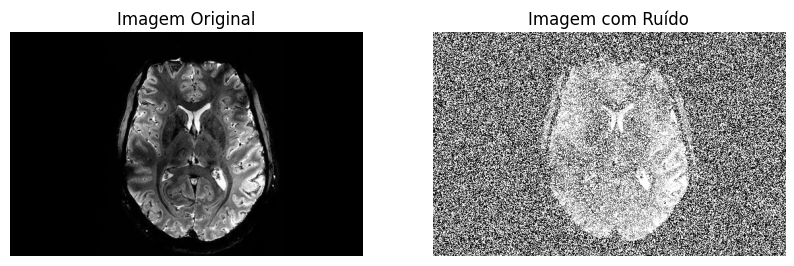

In [67]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow  # Usando a função adequada para o Colab

def load_img(path):
    img = cv2.imread(path)
    if img is None:
        print("Imagem não encontrada")
        return None
    # Converter para escala de cinza manualmente
    gray = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])
    return gray

def add_gaussian_noise(img, mean=0, std_dev=25):
    noise = np.random.normal(mean, std_dev, img.shape).astype(np.uint8)
    noisy_img = np.clip(img + noise, 0, 255)
    return noisy_img

# Carregar imagem
img_path = '/content/Cerebro-RaioX.png'  # Substitua pelo caminho da imagem
gray = load_img(img_path)

if gray is not None:
    # Adicionar ruído gaussiano
    noisy_gray = add_gaussian_noise(gray, mean=0, std_dev=25)

    # Exibir as duas imagens (original e com ruído) lado a lado
    plt.figure(figsize=(10, 5))

    # Imagem original
    plt.subplot(1, 2, 1)
    plt.imshow(gray, cmap='gray')
    plt.title('Imagem Original')
    plt.axis('off')

    # Imagem com ruído
    plt.subplot(1, 2, 2)
    plt.imshow(noisy_gray, cmap='gray')
    plt.title('Imagem com Ruído')
    plt.axis('off')

    plt.show()


#Filtro da média (suavização)

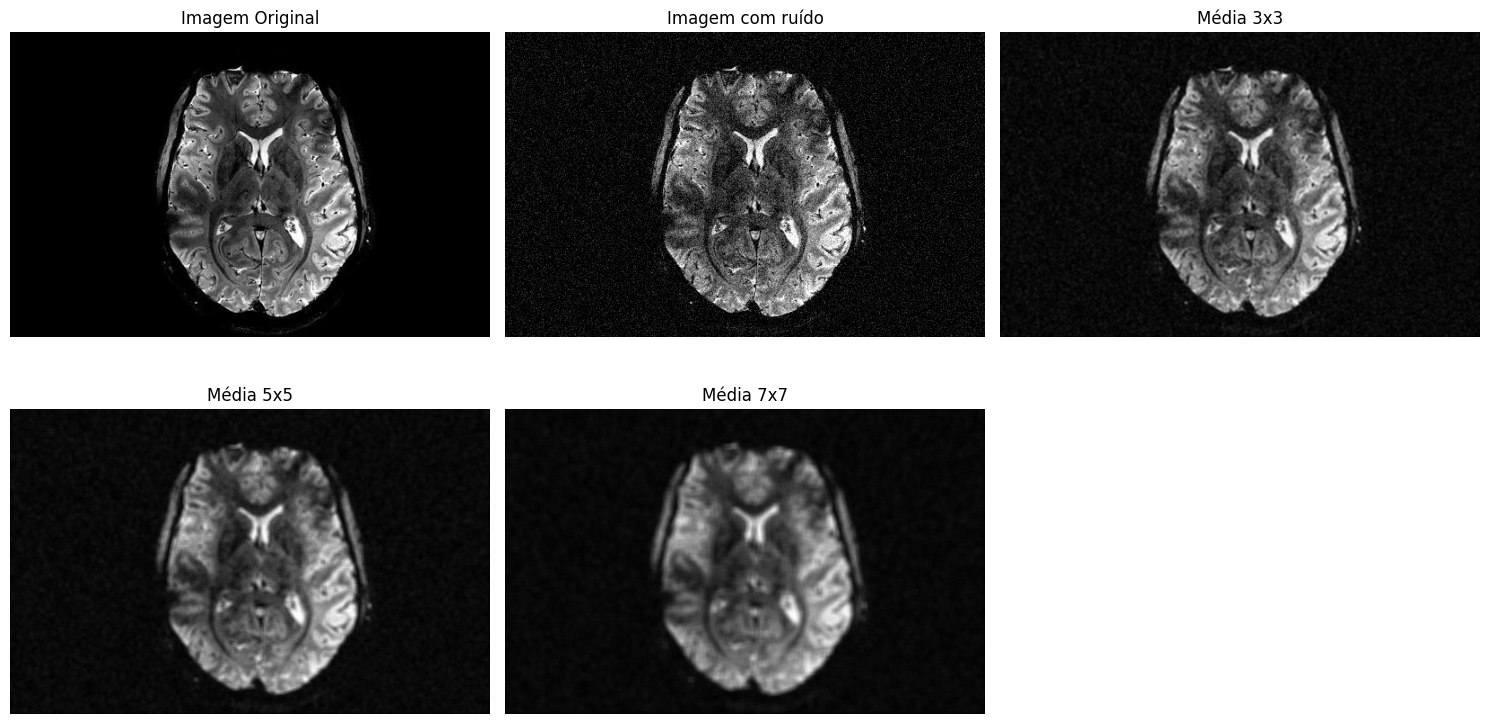

In [33]:
#criação kernel da média
def create_mean_kernel(size):
  return np.ones((size, size)) / (size * size)

#convulação
def convulation(img, kernel):
  k = kernel.shape[0]
  pad = k//2
  height, width = img.shape
  padded = np.zeros((height + 2 * pad, width + 2 * pad), dtype=np.float32)

  #colocar a imagem para o centro do pad
  for i in range(height):
    for j in range(width):
      padded[i + pad, j + pad] = img[i, j]

  output = np.zeros((height, width), dtype=np.float32)

  for i in range(height):
    for j in range(width):
      acc = 0.0
      for m in range(k):
        for n in range(k):
          acc += padded[i + m, j + n] * kernel[m, n]
      output[i, j] = acc
  return np.clip(output, 0, 255).astype(np.uint8)

#aplicar filtros de média com tamanhos variados
def apply_mean_filters(img, kernel_sizes=[3, 5, 7]):
  results = []
  for size in kernel_sizes:
    kernel = create_mean_kernel(size)
    filtered = convulation(img, kernel)
    results.append({
        'size': size,
        'mean': filtered
    })
  return results

#exibir imagens
def display_mean_filters(original, noisy, filtered_images):
  plt.figure(figsize=(15, 8))

  plt.subplot(2, 3, 1)
  plt.imshow(original, cmap='gray')
  plt.title("Imagem Original")
  plt.axis('off')

  plt.subplot(2, 3, 2)
  plt.imshow(noisy, cmap='gray')
  plt.title("Imagem com ruído")
  plt.axis('off')

  idx = 3
  for res in filtered_images:
    plt.subplot(2, 3, idx)
    plt.imshow(res['mean'], cmap='gray')
    plt.title(f'Média {res["size"]}x{res["size"]}')
    plt.axis('off')
    idx += 1

  plt.tight_layout()
  plt.show()

#execução
img_path = 'Cerebro-RaioX.png'
img = load_img(img_path)

if img is not None:
  noisy_img = add_gaussian_noise(img)
  filtered = apply_mean_filters(noisy_img)
  display_mean_filters(img, noisy_img, filtered)

Filtro da mediana (remoção de ruído)

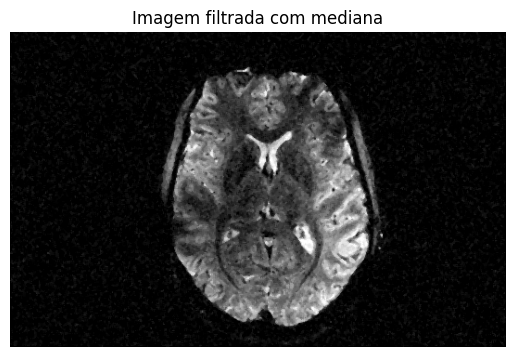

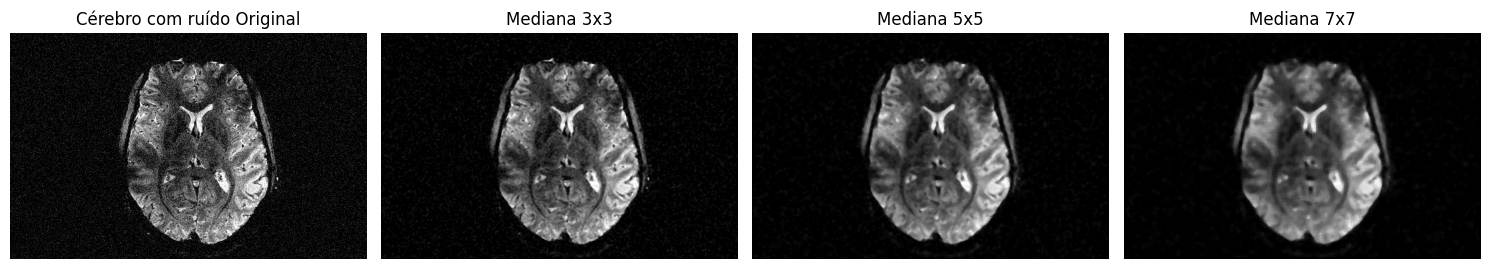

In [34]:
import matplotlib.pyplot as plt
import cv2

#funcao para aplicar padding
def pad_image(img, pad):
    height = len(img)
    width = len(img[0])
    new_height = height + 2 * pad
    new_width = width + 2 * pad

    padded = [[0 for _ in range(new_width)] for _ in range(new_height)]

    for i in range(height):
        for j in range(width):
            padded[i + pad][j + pad] = img[i][j]
    return padded

#calculo da mediana
def median(values):
    sorted_vals = sorted(values)
    n = len(sorted_vals)
    mid = n // 2
    if n % 2 == 0:
        return (sorted_vals[mid - 1] + sorted_vals[mid]) // 2
    else:
        return sorted_vals[mid]

def median_filter(img, k=3):
    pad = k // 2
    height = len(img)
    width = len(img[0])
    padded = pad_image(img, pad)

    result = [[0 for _ in range(width)] for _ in range(height)]

    for i in range(height):
        for j in range(width):
            window = []
            for ki in range(k):
                for kj in range(k):
                    window.append(padded[i + ki][j + kj])
            result[i][j] = median(window)

    return np.array(result, dtype=np.uint8)

#aplicacao do filtro com varios tamanhos
def apply_filters_medians(img, sizes=[3, 5, 7]):
  results = []
  for k in sizes:
    result = median_filter(img, k)
    results.append((k, result))
  return results

#exibicao
def show_results(original, results, img_name="Imagem"):
  plt.figure(figsize=(15, 5))
  plt.subplot(1, len(results)+1, 1)
  plt.imshow(original, cmap='gray')
  plt.title(f"{img_name} Original")
  plt.axis('off')

  for idx, (k, img_filt) in enumerate(results, start=2):
    plt.subplot(1, len(results)+1, idx)
    plt.imshow(img_filt, cmap='gray')
    plt.title(f"Mediana {k}x{k}")
    plt.axis('off')

  plt.tight_layout()
  plt.show()

#execucao
img = load_img("Cerebro-RaioX.png")
noisy_img = add_gaussian_noise(img)

brain_median = median_filter(noisy_img)
plt.imshow(brain_median, cmap='gray')
plt.title("Imagem filtrada com mediana")
plt.axis('off')
plt.show()

median_results = apply_filters_medians(noisy_img)
show_results(noisy_img, median_results, img_name="Cérebro com ruído")

Filtro Laplaciano (realce de bordas)

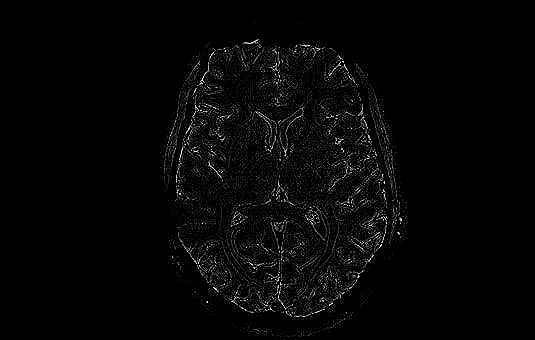

In [35]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

#funcao de converter a imagem BGR para listas de listas
def bgr_to_list(img_cv2):
    return [[tuple(pixel) for pixel in row] for row in img_cv2]

#converter imagem BGR para tons de cinza
def rgb_to_gray(img_color):
    height = len(img_color)
    width = len(img_color[0])
    gray = [[0 for _ in range(width)] for _ in range(height)]
    for i in range(height):
        for j in range(width):
            b, g, r = img_color[i][j]
            gray[i][j] = int(0.299 * r + 0.587 * g + 0.114 * b)
    return gray

#padding
def pad_image(img, pad=1):
    height = len(img)
    width = len(img[0])
    padded = [[0 for _ in range(width + 2 * pad)] for _ in range(height + 2 * pad)]
    for i in range(height):
        for j in range(width):
            padded[i + pad][j + pad] = img[i][j]
    return padded

#Laplaciano
def laplacian_filter(img):
    kernel = [[0, -1, 0],
              [-1, 4, -1],
              [0, -1, 0]]
    padded = pad_image(img, 1)
    height = len(img)
    width = len(img[0])
    result = [[0 for _ in range(width)] for _ in range(height)]

    for i in range(height):
        for j in range(width):
            soma = 0
            for ki in range(3):
                for kj in range(3):
                    valor_pixel = padded[i + ki][j + kj]
                    valor_kernel = kernel[ki][kj]
                    soma += valor_pixel * valor_kernel
            #clamping
            result[i][j] = min(255, max(0, soma))

    result_img = np.array(result, dtype=np.uint8)
    return result_img

img_cerebro = cv2.imread("/content/Cerebro-RaioX.png")

img_cerebro_list = bgr_to_list(img_cerebro)

img_cerebro_gray = rgb_to_gray(img_cerebro_list)

laplaciano_cerebro = laplacian_filter(img_cerebro_gray)

cv2_imshow(laplaciano_cerebro)


#Filtro Passa-Baixa com Fourier


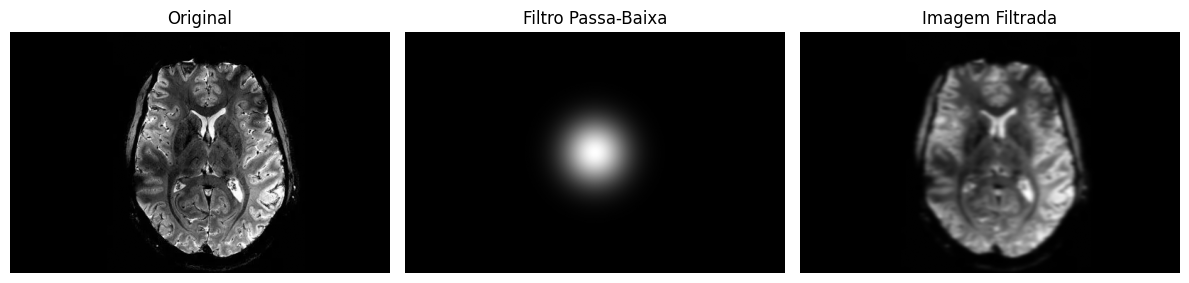

In [36]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Função para criar filtro passa-baixa (ideal, Butterworth ou Gaussiano)
def createPB(shape, center, radius, lpType=2, n=2):
    rows, cols = shape[:2]
    r, c = np.mgrid[0:rows, 0:cols]
    c -= center[0]
    r -= center[1]
    d = np.sqrt(r**2 + c**2)

    if lpType == 0:  # Ideal
        lpFilter = np.zeros(shape, np.float32)
        lpFilter[d <= radius] = 1
    elif lpType == 1:  # Butterworth
        lpFilter = 1 / (1 + (d / (radius + 1e-5))**(2 * n))
    elif lpType == 2:  # Gaussiano
        lpFilter = np.exp(-(d**2) / (2 * (radius**2)))

    return lpFilter

# DFT 2D manual (vetorizada via matriz)
def dft2d(img):
    M, N = img.shape
    x = np.arange(M)
    y = np.arange(N)
    u = x.reshape((M, 1))
    v = y.reshape((N, 1))

    W_M = np.exp(-2j * np.pi * u * x / M)
    W_N = np.exp(-2j * np.pi * v * y / N)
    return W_M @ img @ W_N.T

# IDFT 2D manual
def idft2d(dft_img):
    M, N = dft_img.shape
    x = np.arange(M)
    y = np.arange(N)
    u = x.reshape((M, 1))
    v = y.reshape((N, 1))

    W_M_inv = np.exp(2j * np.pi * u * x / M)
    W_N_inv = np.exp(2j * np.pi * v * y / N)
    return np.real(W_M_inv @ dft_img @ W_N_inv.T) / (M * N)

# Carregar imagem
img = cv2.imread("Cerebro-RaioX.png", cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float32) / 255.0

# Aplicar DFT manual
f = dft2d(img)
fshift = np.fft.fftshift(f)

# Criar máscara passa-baixa
rows, cols = img.shape
center = (cols // 2, rows // 2)
radius = 30
mask = createPB((rows, cols), center, radius, lpType=2)

# Aplicar filtro
filtered = fshift * mask

# Transformada inversa
f_ishift = np.fft.ifftshift(filtered)
img_back = idft2d(f_ishift)

# Mostrar
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Filtro Passa-Baixa")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Imagem Filtrada")
plt.imshow(img_back, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


#Filtro Passa-Alta com Fourier

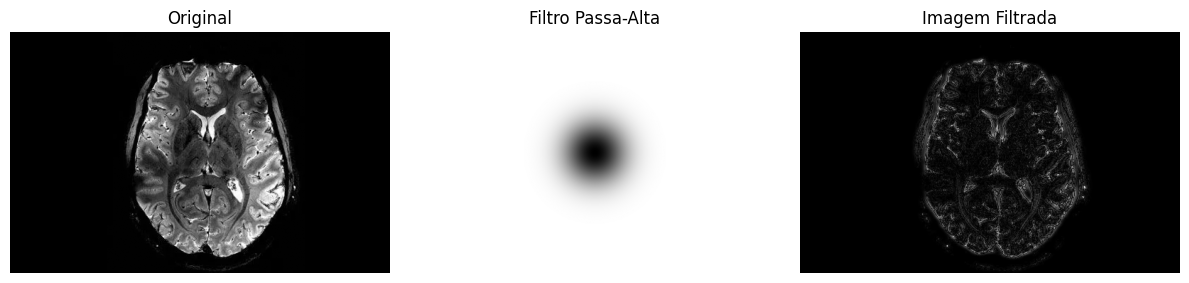

In [37]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def createPA(shape, center, radius, lpType=2, n=2):
    rows, cols = shape[:2]
    r, c = np.mgrid[0:rows, 0:cols]
    c = c - center[0]
    r = r - center[1]
    d = np.sqrt(np.power(r, 2) + np.power(c, 2))
    lpFilter_matrix = np.zeros(shape, np.float32)

    if lpType == 0:  # Ideal high pass filter
        lpFilter = np.copy(d)
        lpFilter[d <= radius] = 0
        lpFilter[d > radius] = 1
    elif lpType == 1:  # Butterworth Highpass Filter
        lpFilter = 1 / (1 + (radius / (d + 1e-5)) ** (2 * n))
    elif lpType == 2:  # Gaussian Highpass Filter
        lpFilter = 1 - np.exp(-(d ** 2) / (2 * (radius ** 2)))

    lpFilter_matrix[:, :] = lpFilter
    return lpFilter_matrix

# Função otimizada para DFT 2D com vetorização
def dft2d(img):
    M, N = img.shape
    x = np.arange(M)
    y = np.arange(N)
    u = x.reshape((M, 1))
    v = y.reshape((N, 1))

    # Matriz de transformada em cada dimensão
    W_M = np.exp(-2j * np.pi * u * x / M)
    W_N = np.exp(-2j * np.pi * v * y / N)

    # Aplica DFT separável (linha, depois coluna)
    return W_M @ img @ W_N.T


# Função para IDFT manual 2D otimizada
def idft2d(dft_img):
    M, N = dft_img.shape
    x = np.arange(M)
    y = np.arange(N)
    u = x.reshape((M, 1))
    v = y.reshape((N, 1))

    # Matriz inversa
    W_M_inv = np.exp(2j * np.pi * u * x / M)
    W_N_inv = np.exp(2j * np.pi * v * y / N)

    # Aplica IDFT
    return np.real(W_M_inv @ dft_img @ W_N_inv.T) / (M * N)


# Carregar imagem
img = cv2.imread("Cerebro-RaioX.png", cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float32) / 255.0  # Normalizar

# DFT manual otimizada 2D
f = dft2d(img)
fshift = np.fft.fftshift(f)  # Shift para centralizar frequências baixas

# Criar máscara passa-alta
rows, cols = img.shape
center = (cols // 2, rows // 2)
radius = 30  # valor de corte
mask = createPA((rows, cols), center, radius, lpType=2)

# Aplicar máscara
filtered = fshift * mask

# IDFT manual otimizada 2D
f_ishift = np.fft.ifftshift(filtered)  # Shift de volta
img_back = idft2d(f_ishift)
img_back = np.abs(img_back)  # Pegando a magnitude da imagem filtrada

# Mostrar
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Filtro Passa-Alta")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Imagem Filtrada")
plt.imshow(img_back, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


#Passa-banda

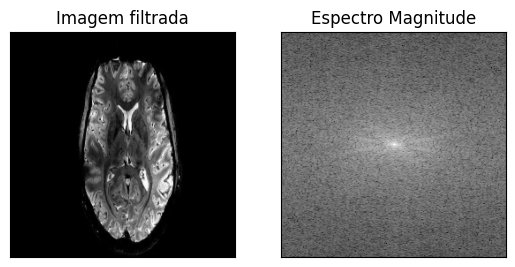

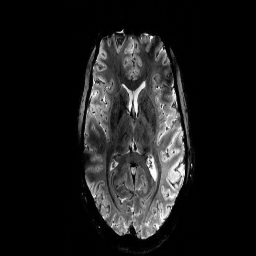

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2

def createPF(shape, center, bandCenter, bandWidth, lpType=2, n=2):
    rows, cols = shape[:2]
    r, c = np.mgrid[:rows, :cols]
    c -= center[0]
    r -= center[1]
    d = np.sqrt(r**2 + c**2)
    lpFilter_matrix = np.zeros(shape, np.float32)

    if lpType == 0:  # Ideal
        lpFilter = np.copy(d)
        lpFilter[:, :] = 0
        lpFilter[(d >= bandCenter - bandWidth / 2) & (d <= bandCenter + bandWidth / 2)] = 1
    elif lpType == 1:  # Butterworth
        lpFilter = 1 / (1 + ((d * bandWidth) / (d**2 - bandCenter**2 + 1e-5))**(2 * n))
    elif lpType == 2:  # Gaussiano
        lpFilter = np.exp(-((d - bandCenter) ** 2) / (2 * (bandWidth / 2) ** 2))

    lpFilter_matrix[:, :] = lpFilter
    return lpFilter_matrix

# Carregar imagem
img = cv2.imread("Cerebro-RaioX.png", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256))  # reduz a imagem para ser mais leve
img_float = np.float32(img)

# Aplicar DFT com OpenCV
dft = cv2.dft(img_float, flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# Criar filtro
shape = img.shape
center = (shape[1] // 2, shape[0] // 2)
maskPF = createPF(shape=dft_shift.shape[:2], center=center, bandCenter=1, bandWidth=400, lpType=2, n=2)

# Aplicar o filtro
filtered_freq = np.zeros_like(dft_shift)
filtered_freq[:, :, 0] = dft_shift[:, :, 0] * maskPF
filtered_freq[:, :, 1] = dft_shift[:, :, 1] * maskPF

# Inverter o deslocamento e aplicar IDFT
f_ishift = np.fft.ifftshift(filtered_freq)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

# Normalizar a imagem para exibição
filtered_img = np.abs(img_back)
filtered_img -= filtered_img.min()
filtered_img = (filtered_img * 255) / filtered_img.max()
filtered_img = filtered_img.astype(np.uint8)

# Mostrar com matplotlib
plt.subplot(121), plt.imshow(filtered_img, cmap='gray')
plt.title('Imagem filtrada'), plt.xticks([]), plt.yticks([])

magnitude_spectrum = 20 * np.log(1 + cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Espectro Magnitude'), plt.xticks([]), plt.yticks([])
plt.show()

# Mostrar com OpenCV
cv2_imshow(filtered_img)

#Rejeita-banda

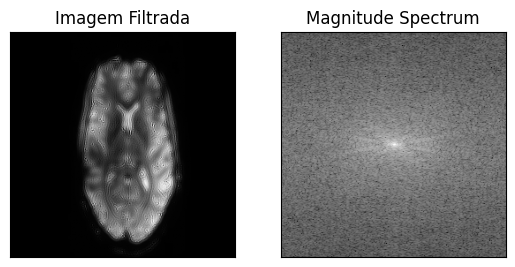

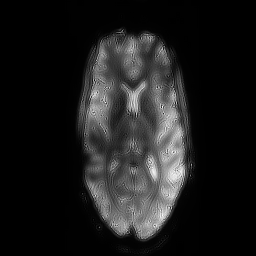

In [39]:
def createRF(shape, center, bandCenter, bandWidth, lpType=2, n=2):
    rows, cols = shape[:2]
    r, c = np.mgrid[:rows, :cols]  # grade de coordenadas
    c -= center[0]
    r -= center[1]
    d = np.sqrt(np.power(r, 2) + np.power(c, 2))  # distância até o centro

    lpFilter_matrix = np.zeros(shape, np.float32)

    if lpType == 0:  # Ideal Band Stop Filter
        lpFilter = np.ones_like(d, dtype=np.float32)  # tudo passa por padrão
        lpFilter[(d >= bandCenter - bandWidth / 2) & (d <= bandCenter + bandWidth / 2)] = 0  # rejeita a banda

    elif lpType == 1:  # Butterworth Band Stop Filter
        epsilon = 1e-5  # para evitar divisão por zero
        lpFilter = 1 / (1 + ((bandWidth * d) / (np.square(d) - bandCenter**2 + epsilon))**(2 * n))

    elif lpType == 2:  # Gaussian Band Stop Filter
        lpFilter = 1 - np.exp(-((d - bandCenter) ** 2) / (2 * (bandWidth / 2) ** 2))

    lpFilter_matrix[:, :] = lpFilter
    return lpFilter_matrix
center = (img.shape[1] // 2, img.shape[0] // 2)  # centro da imagem
maskRF = createRF(shape=dft_shift.shape[:2], center=center, bandCenter=50, bandWidth=50, lpType=2, n=2)

# Aplicar o filtro no domínio da frequência
filtered_freq = np.zeros_like(dft_shift)
filtered_freq[:, :, 0] = dft_shift[:, :, 0] * maskRF
filtered_freq[:, :, 1] = dft_shift[:, :, 1] * maskRF

# Inverter o deslocamento e aplicar IDFT
f_ishift = np.fft.ifftshift(filtered_freq)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])  # intensidade da imagem

img_back = np.array(img_back, dtype=np.float32)

plt.subplot(121), plt.imshow(img_back, cmap='gray')
plt.title('Imagem Filtrada'), plt.xticks([]), plt.yticks([])

magnitude_spectrum = 20 * np.log(1 + cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

plt.show()

filtered_img = np.abs(img_back)
filtered_img -= filtered_img.min()
filtered_img = (filtered_img * 255) / filtered_img.max()
filtered_img = filtered_img.astype(np.uint8)
cv2_imshow(filtered_img)

#Operações Morfológicas

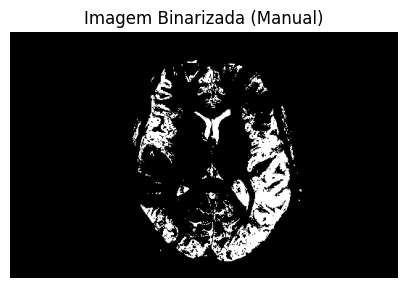

In [53]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Função de binarização manual otimizada com NumPy
def binarizar_manual(img, limiar=127):
    binaria = np.zeros_like(img)  # Inicializar uma imagem com 0 (preto)

    for i in range(len(img)):
        for j in range(len(img[0])):
            if img[i][j] > limiar:
                binaria[i][j] = 255  # Atribuir 255 (branco) se maior que o limiar
            else:
                binaria[i][j] = 0  # Caso contrário, 0 (preto)

    return binaria

# Carregar imagens em tons de cinza
def load_img(path):
    img_rgb = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img_rgb is None:
        raise ValueError(f"Imagem não encontrada em {path}")
    return img_rgb

# Carregar as imagens
img_cerebro = load_img('/content/Cerebro-RaioX.png')
#img_babuino = load_img('/content/babuino.jpg')
#img_arara = load_img('/content/arara.jpg')

# Aplicar a binarização nas imagens
img_binaria_cerebro = binarizar_manual(img_cerebro, 127)
#img_binaria_babuino = binarizar_manual(img_babuino, 127)
#img_binaria_arara = binarizar_manual(img_arara, 127)

# Exibir as imagens binarizadas
plt.figure(figsize=(5, 5))
plt.title("Imagem Binarizada (Manual)")
plt.imshow(img_binaria_cerebro, cmap='gray')
plt.axis('off')
plt.show()

#plt.figure(figsize=(10,5))
#plt.subplot(1, 2, 1)
#plt.title("Babuino Binária")
#plt.imshow(img_binaria_babuino, cmap='gray')
#plt.axis('off')

#plt.subplot(1, 2, 2)
#plt.title("Arara Binária")
#plt.imshow(img_binaria_arara, cmap='gray')
#plt.axis('off')

plt.show()


2.1 – Dilatação

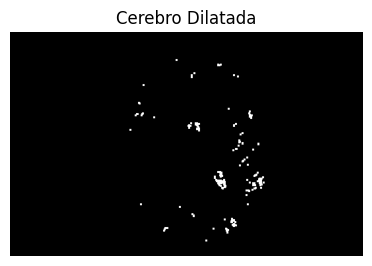

In [54]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Função de dilatação manual sem usar funções prontas como np.pad ou np.any
# Função de dilatação manual
def dilatacao(img, kernel_size=3):
    offset = kernel_size // 2
    padded = np.zeros((len(img) + 2 * offset, len(img[0]) + 2 * offset))  # Preencher com 0
    padded[offset:-offset, offset:-offset] = img  # Colocar a imagem original no centro

    resultado = np.zeros_like(img)  # Resultado inicializado com 0

    # Percorrer a imagem e aplicar a dilatação
    for i in range(offset, len(padded) - offset):
        for j in range(offset, len(padded[0]) - offset):
            região = padded[i - offset:i + offset + 1, j - offset:j + offset + 1]
            if np.any(região == 255):  # Verificar se algum pixel da região é 255
                resultado[i - offset, j - offset] = 255

    return resultado

# Carregar as imagens binarizadas
def load_img(path):
    img_rgb = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img_rgb is None:
        raise ValueError(f"Imagem não encontrada em {path}")
    return img_rgb

# Carregar as imagens binarizadas (já aplicadas antes)
img_cerebro = load_img('/content/Cerebro-RaioX.png')
#img_babuino = load_img('/content/babuino.jpg')
#img_arara = load_img('/content/arara.jpg')

# Aplicar a dilatação nas imagens binarizadas
img_dilatada_cerebro = dilatacao(img_cerebro)
#img_dilatada_babuino = dilatacao(img_babuino)
#img_dilatada_arara = dilatacao(img_arara)

# Exibir as imagens dilatadas
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Cerebro Dilatada")
plt.imshow(img_dilatada_cerebro, cmap='gray')
plt.axis('off')

#plt.figure(figsize=(10, 5))
#plt.subplot(1, 2, 1)
#plt.title("Babuino Dilatada")
#plt.imshow(img_dilatada_babuino, cmap='gray')
#plt.axis('off')

#plt.subplot(1, 2, 2)
#plt.title("Arara Dilatada")
#plt.imshow(img_dilatada_arara, cmap='gray')
#plt.axis('off')

plt.show()


#2.2 – Erosão

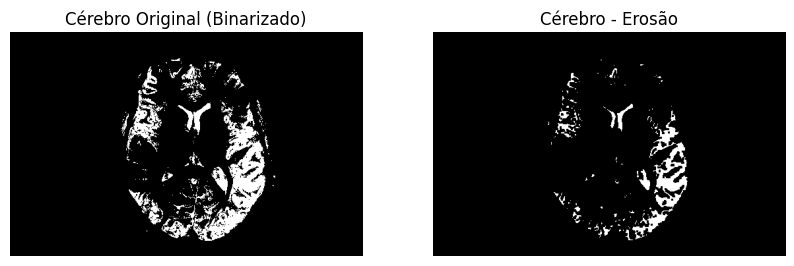

In [55]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Função de erosão manual
def erosao(img, kernel_size=3):
    offset = kernel_size // 2
    padded = np.full((len(img) + 2 * offset, len(img[0]) + 2 * offset), 255)  # Preencher com 255
    padded[offset:-offset, offset:-offset] = img

    resultado = np.zeros_like(img)

    for i in range(offset, len(padded) - offset):
        for j in range(offset, len(padded[0]) - offset):
            regiao = padded[i - offset:i + offset + 1, j - offset:j + offset + 1]
            if np.all(regiao == 255):  # Todos os pixels da vizinhança devem ser 255
                resultado[i - offset, j - offset] = 255

    return resultado

# Carregar a imagem
def load_img(path):
    img_rgb = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img_rgb is None:
        raise ValueError(f"Imagem não encontrada em {path}")
    return img_rgb

# === MAIN ===
img_cerebro = load_img('/content/Cerebro-RaioX.png')

# Binarizar a imagem (operação pontual, permitida)
img_binaria_cerebro = np.where(img_cerebro > 127, 255, 0).astype(np.uint8)

# Aplicar erosão
img_erosao_cerebro = erosao(img_binaria_cerebro)

# Exibir
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Cérebro Original (Binarizado)")
plt.imshow(img_binaria_cerebro, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Cérebro - Erosão")
plt.imshow(img_erosao_cerebro, cmap='gray')
plt.axis('off')
plt.show()


#2.3 – Abertura (erosão seguida de dilatação)

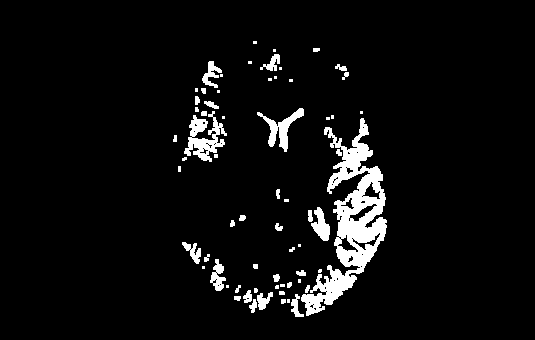

In [56]:
def abertura(img, kernel_size=3):
    return dilatacao(erosao(img, kernel_size), kernel_size)

img_abertura_cerebro = abertura(img_binaria_cerebro)
#img_abertura_babuino = abertura(img_binaria_babuino)
#img_abertura_arara = abertura(img_binaria_arara)

cv2_imshow(img_abertura_cerebro)
#cv2_imshow(img_abertura_babuino)
#cv2_imshow(img_abertura_arara)


#2.4 – Fechamento (dilatação seguida de erosão)

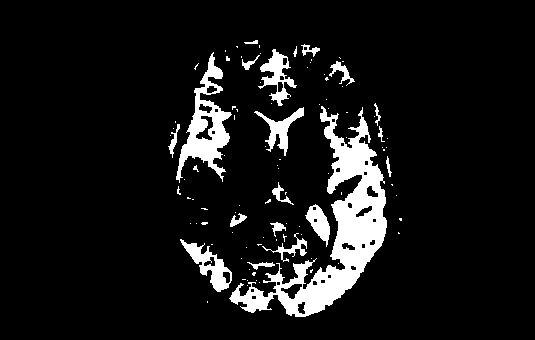

In [57]:
def fechamento(img, kernel_size=3):
    return erosao(dilatacao(img, kernel_size), kernel_size)

img_fechamento_cerebro = fechamento(img_binaria_cerebro)
#img_fechamento_babuino = fechamento(img_binaria_babuino)
#img_fechamento_arara = fechamento(img_binaria_arara)

cv2_imshow(img_fechamento_cerebro)
#cv2_imshow(img_fechamento_babuino)
#cv2_imshow(img_fechamento_arara)

#Binarização

In [51]:
def binarizar(img, limiar=127):
    # Criar a imagem binarizada manualmente
    binaria = [[0 for _ in range(len(img[0]))] for _ in range(len(img))]

    for i in range(len(img)):
        for j in range(len(img[0])):
            binaria[i][j] = 255 if img[i][j] > limiar else 0

    return binaria

#Usabilidade


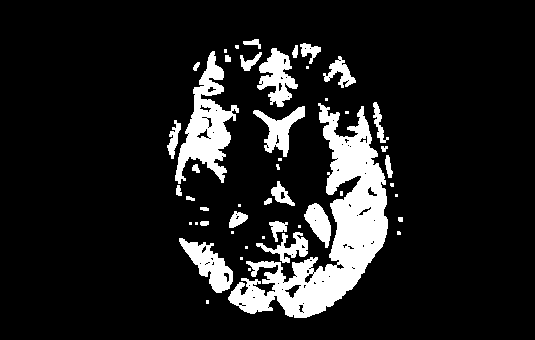

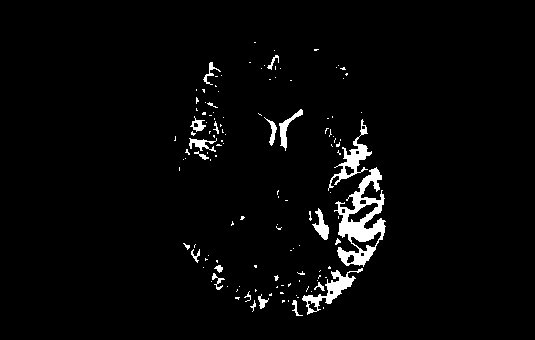

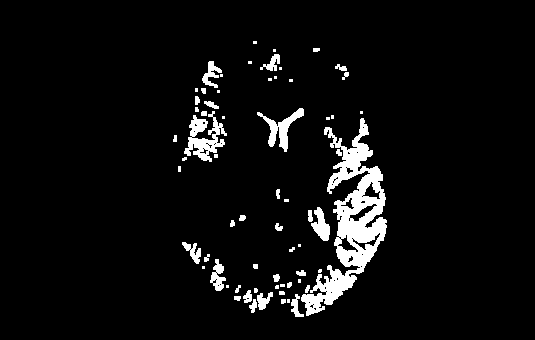

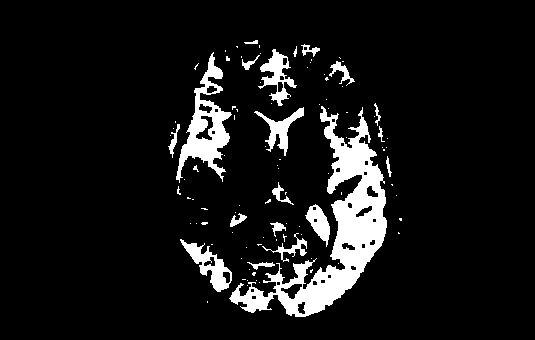

In [59]:
# Carregar as imagens binarizadas
img_cerebro = load_img('/content/Cerebro-RaioX.png')

# Aplicar a binarização na imagem do cérebro
img_binaria_cerebro = binarizar(img_cerebro, 127)
img_binaria_cerebro = np.array(img_binaria_cerebro, dtype=np.uint8)
#img_babuino = load_img('/content/babuino.jpg')
#img_arara = load_img('/content/arara.jpg')

# Aplicar as operações morfológicas nas imagens
#img_dilatada_babuino = dilatacao(img_babuino)
#img_erodida_babuino = erosao(img_babuino)
#img_aberta_babuino = abertura(img_babuino)
#img_fechada_babuino = fechamento(img_babuino)

img_dilatada_cerebro = dilatacao(img_binaria_cerebro)
img_erodida_cerebro = erosao(img_binaria_cerebro)
img_aberta_cerebro = abertura(img_binaria_cerebro)
img_fechada_cerebro = fechamento(img_binaria_cerebro)

#img_dilatada_arara = dilatacao(img_arara)
#img_erodida_arara = erosao(img_arara)
#img_aberta_arara = abertura(img_arara)
#img_fechada_arara = fechamento(img_arara)

# Exibir os resultados
cv2_imshow(img_dilatada_cerebro)
cv2_imshow(img_erodida_cerebro)
cv2_imshow(img_aberta_cerebro)
cv2_imshow(img_fechada_cerebro)

#cv2_imshow(img_dilatada_babuino)
#cv2_imshow(img_erodida_babuino)
#cv2_imshow(img_aberta_babuino)
#cv2_imshow(img_fechada_babuino)

#cv2_imshow(img_dilatada_arara)
#cv2_imshow(img_erodida_arara)
#cv2_imshow(img_aberta_arara)
#cv2_imshow(img_fechada_arara)
